In [1]:
# Imports

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from rnanorm import CPM  # Install with: pip install rnanorm

### This code block trains and evaluates three different models (SVM, Logistic Regression, and XGBoost) on a given dataset using the significant genes as features.
### It preprocesses the data, selects significant genes, trains the models, evaluates their performance, and visualizes the results.
### The code also returns the name of the best performing model and saves the top 3000 ranked genes from this model.

Training SVM with Significant...

SVM - Metrics:
CV Accuracy: 0.9474
Test Accuracy: 0.9643


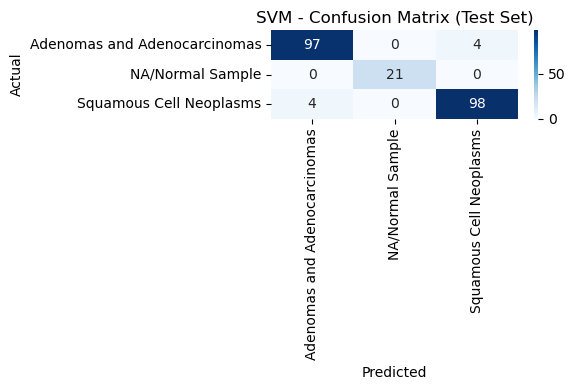

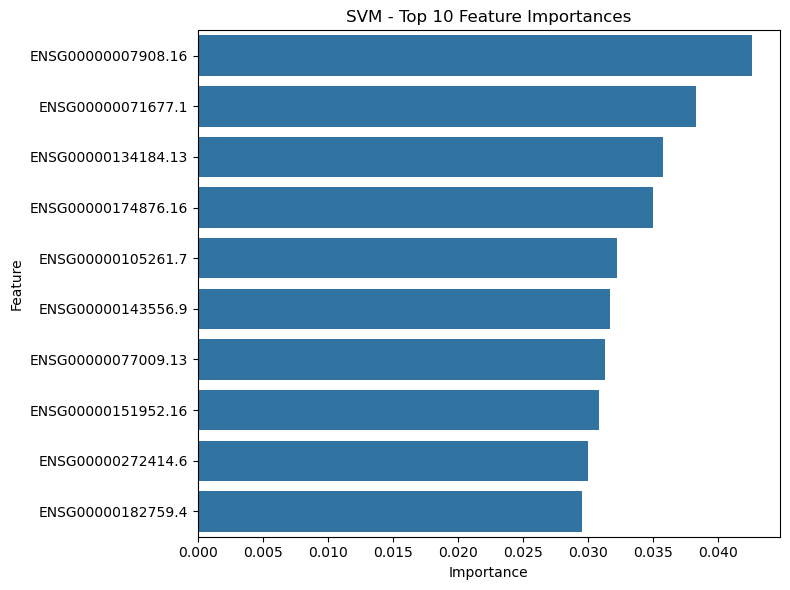

Training LogisticRegression with Significant...

LogisticRegression - Metrics:
CV Accuracy: 0.9519
Test Accuracy: 0.9688


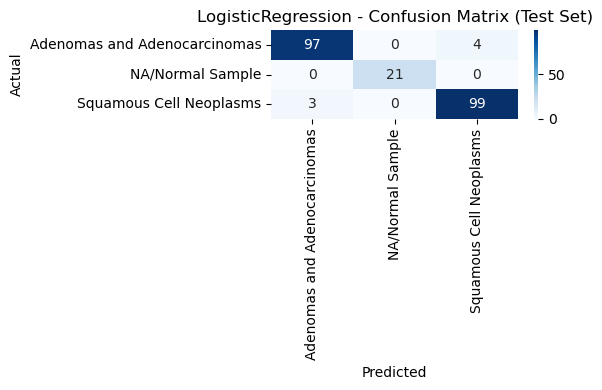

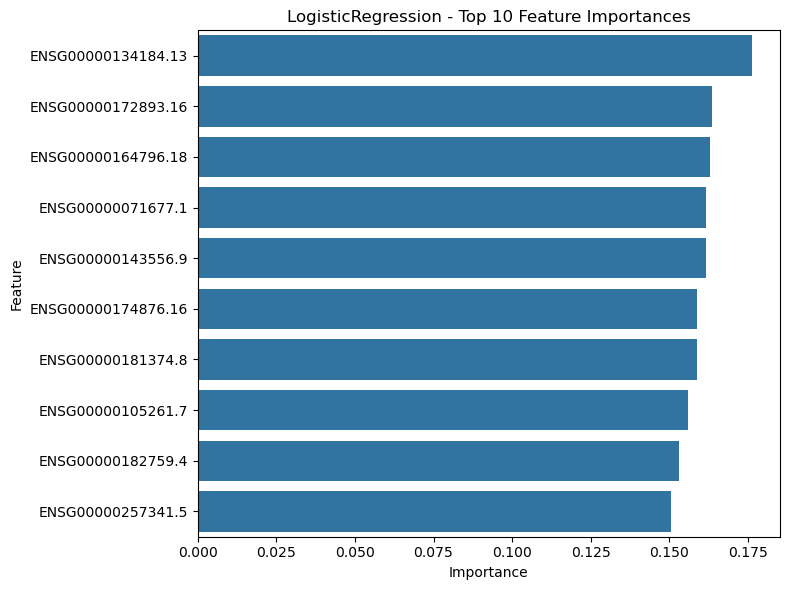

Training XGBoost with Significant...

XGBoost - Metrics:
CV Accuracy: 0.9485
Test Accuracy: 0.9777


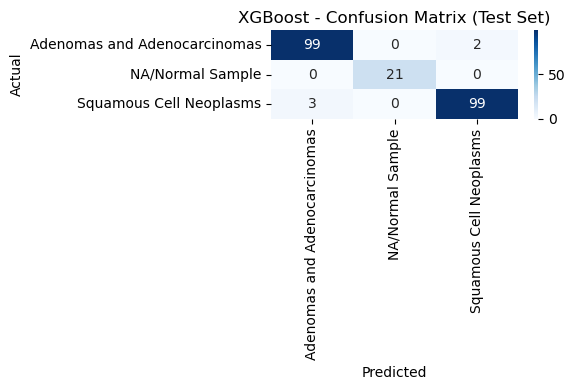

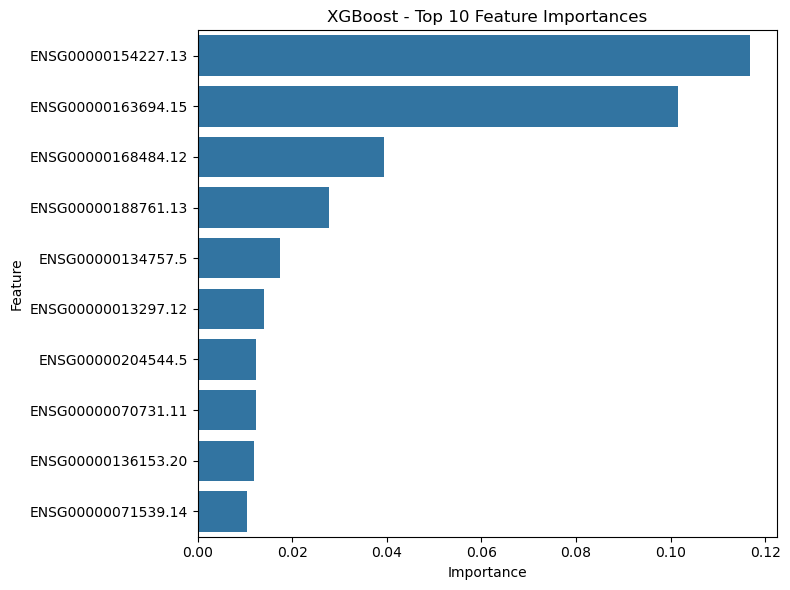


Best performing model - for sig genes: XGBoost_Significant


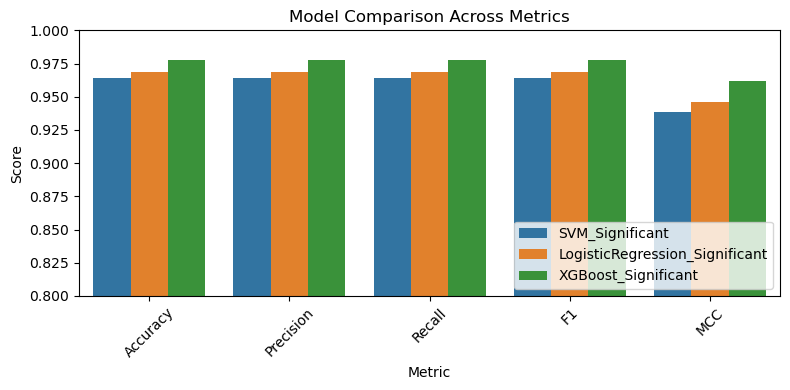

In [2]:
from sig_genes import preprocess_data, select_significant_genes, train_and_evaluate_models_sig, plot_comparison

# ----------------------- 1. Pipeline 1 -----------------------
def run_pipeline_1(train_csv, test_csv, significant_genes_file):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    with open(significant_genes_file, "r") as f:
        sig_gene_list = [line.strip() for line in f]

    sig_genes = select_significant_genes(train_df, sig_gene_list)
    train_sig = train_df[['cases.disease_type'] + sig_genes]
    test_sig = test_df[['cases.disease_type'] + sig_genes]

    X_train_sig, y_train_sig, scaler_sig, le_sig = preprocess_data(train_sig)
    X_test_sig, y_test_sig, _, _ = preprocess_data(test_sig, scaler=scaler_sig, fit_scaler=False)

    results_significant, model_top_genes = train_and_evaluate_models_sig(X_train_sig, y_train_sig, X_test_sig, y_test_sig, le_sig, 'Significant', sig_genes)
    
    # Select best model by test accuracy
    best_model_name = max(results_significant, key=lambda k: results_significant[k]['Accuracy'])  
    print(f"\nBest performing model - for sig genes: {best_model_name}")
    
    # Save full ranking from best model
    ranked_genes = model_top_genes[best_model_name]
    with open("ranked_sig_genes.txt", "w") as f:
        f.write("\n".join(ranked_genes))
    
    return results_significant, model_top_genes, best_model_name

# ----------------------- 2. Run Pipeline -----------------------
if __name__ == "__main__":
    train_csv = "Data/compiled_train.csv"
    test_csv = "Data/compiled_test.csv"
    sig_genes_file = "Data/intersection_sig_genes.txt"

    results_significant, model_top_genes, best_model_name = run_pipeline_1(train_csv, test_csv, sig_genes_file)
    plot_comparison(results_significant)
    
# Generates ranked_sig_genes.txt with the top 3000 genes from the best model


### This code block trains and evaluates the best model (XGBoost) on both significant and random genes, and compares the results.

XGBoost

=== Training XGBoost ===
On Significant Genes

XGBoost_Sig - Metrics:
CV Accuracy: 0.9463
Test Accuracy: 0.9732
On Random Genes

XGBoost_Rand - Metrics:
CV Accuracy: 0.9396
Test Accuracy: 0.9688


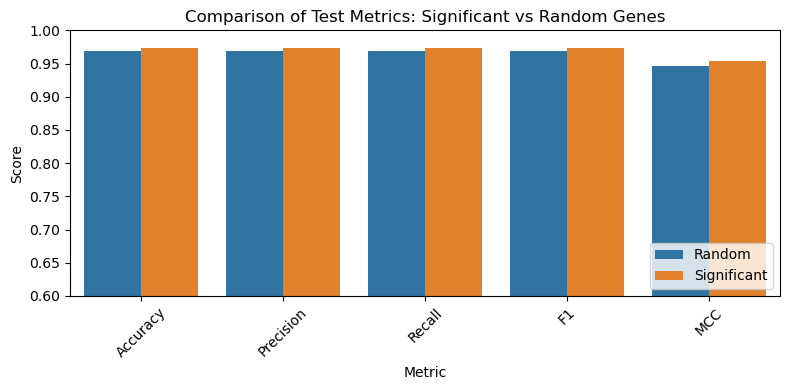

In [5]:

from sig_genes import preprocess_data
from random3000_vs_sig import select_non_overlapping_random_genes, evaluate_model_random_vs_sig, plot_comparison_random_vs_sig

# ----------------------- 1. Pipeline 2 -----------------------
def run_pipeline_2(train_csv, test_csv, significant_genes_file, best_model_type):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    # All significant genes
    with open(significant_genes_file, "r") as f:
        sig_genes = [line.strip() for line in f]

    # DataFrames for significant genes
    train_sig = train_df[['cases.disease_type'] + sig_genes]
    test_sig = test_df[['cases.disease_type'] + sig_genes]

    X_train_sig, y_train_sig, scaler_sig, le_sig = preprocess_data(train_sig)
    X_test_sig, y_test_sig, _, _ = preprocess_data(test_sig, scaler=scaler_sig, fit_scaler=False)

    # Random non-overlapping genes
    rand_genes = select_non_overlapping_random_genes(train_df, sig_genes, num_genes=3000)
    train_rand = train_df[['cases.disease_type'] + rand_genes]
    test_rand = test_df[['cases.disease_type'] + rand_genes]

    X_train_rand, y_train_rand, scaler_rand, le_rand = preprocess_data(train_rand)
    X_test_rand, y_test_rand, _, _ = preprocess_data(test_rand, scaler=scaler_rand, fit_scaler=False)

    # Model selection
    models = {
        'SVM': SVC(kernel='linear', probability=True),
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                                 random_state=42, eval_metric='mlogloss')
    }
    best_model = models[best_model_type]

    print(f"Training {best_model_type}")
    print(f"On Significant Genes...")
    sig_results = evaluate_model_random_vs_sig(f"{best_model_type}_Sig", best_model,
                                 X_train_sig, y_train_sig,
                                 X_test_sig, y_test_sig, le_sig)

    print(f"On Random Genes...")
    rand_results = evaluate_model_random_vs_sig(f"{best_model_type}_Rand", best_model,
                                  X_train_rand, y_train_rand,
                                  X_test_rand, y_test_rand, le_rand)

    return sig_results['Test'], rand_results['Test']  # Only return test results for comparison

# ----------------------- 2. Run Pipeline -----------------------
if __name__ == "__main__":
    train_csv = "Data/compiled_train.csv"
    test_csv = "Data/compiled_test.csv"
    sig_genes_file = "ranked_sig_genes.txt"
    best_model_type = "XGBoost"

    results_sig, results_rand = run_pipeline_2(train_csv, test_csv, sig_genes_file, best_model_type)
    plot_comparison_random_vs_sig(results_rand, results_sig)


### This code block trains and evaluates three different models (SVM, Logistic Regression, and XGBoost) on a given dataset, using all the genes as features.
### It preprocesses the data, and using all of the genes, trains the models, evaluates their performance, and visualizes the results.
### It also returns the name of the best performing model and saves the top 3000 ranked genes from this model.

Training SVM with AllGenes...

SVM - Metrics:
CV Accuracy: 0.9497
Test Accuracy: 0.9821


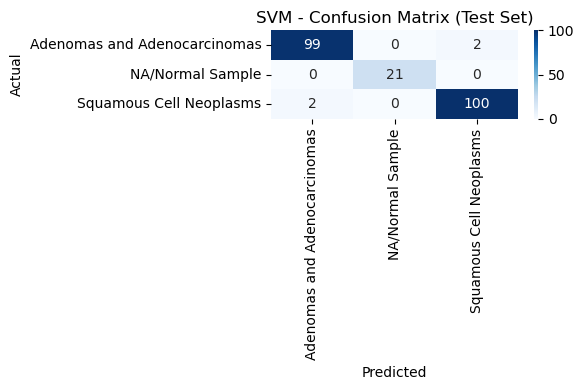

Training LogisticRegression with AllGenes...

LogisticRegression - Metrics:
CV Accuracy: 0.9463
Test Accuracy: 0.9821


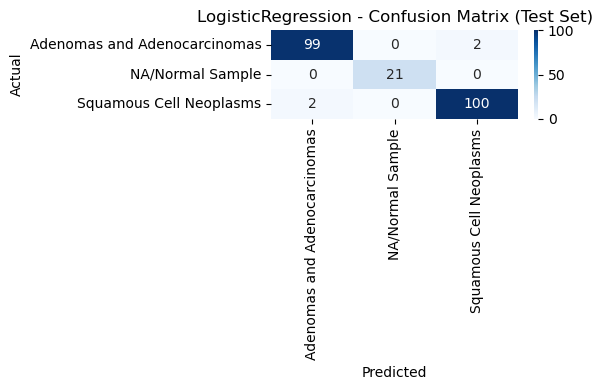

Training XGBoost with AllGenes...

XGBoost - Metrics:
CV Accuracy: 0.9553
Test Accuracy: 0.9777


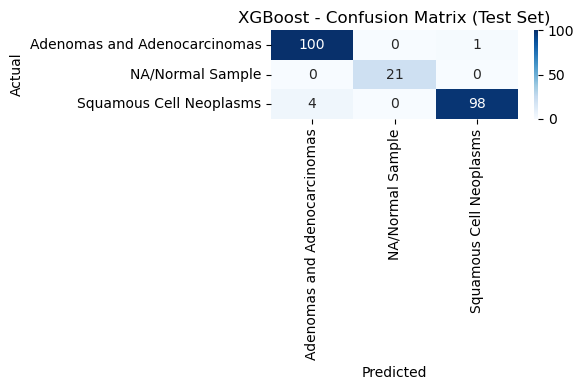


Best performing model: SVM_AllGenes


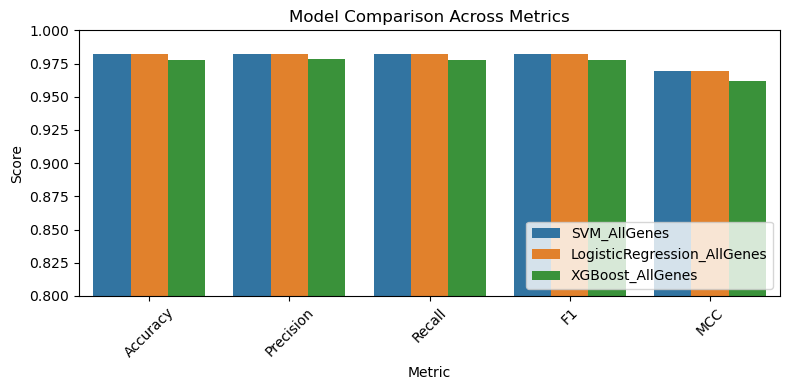

In [ ]:
from sig_genes import preprocess_data, plot_comparison
from all_genes import train_and_evaluate_models_all_genes

# ----------------------- 1. Pipeline 3 -----------------------
def run_pipeline_3(train_csv, test_csv):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)
    
    # Use all genes except label column
    all_genes = train_df.columns.drop('cases.disease_type').tolist()
    
    # Modified to use all genes
    train_all = train_df[['cases.disease_type'] + all_genes]
    test_all = test_df[['cases.disease_type'] + all_genes]

    # Preprocessing remains the same
    X_train_all, y_train_all, scaler_all, le_all = preprocess_data(train_all)
    X_test_all, y_test_all, _, _ = preprocess_data(test_all, scaler=scaler_all, fit_scaler=False)

    # Train models and get top features (modified to return all features)
    results_all, model_top_genes = train_and_evaluate_models_all_genes(
        X_train_all, y_train_all, 
        X_test_all, y_test_all, 
        le_all, 'AllGenes', all_genes
    )
    
    # Select best model
    best_model_name = max(results_all, key=lambda k: results_all[k]['Accuracy'])  
    print(f"\nBest performing model: {best_model_name}")
    
    # Get top 3000 features
    top_3000_genes = model_top_genes[best_model_name][:3000]
    
    # Save to file
    with open("model_sig_genes.txt", "w") as f:
        f.write("\n".join(top_3000_genes))
    
    return results_all, top_3000_genes

# ----------------------- 2. Run Pipeline -----------------------
if __name__ == "__main__":
    train_csv = "Data/compiled_train.csv"
    test_csv = "Data/compiled_test.csv"
    
    # Removed significant_genes_file parameter
    results_all, top_3000_genes = run_pipeline_3(train_csv, test_csv)
    plot_comparison(results_all)


### This code block reads two files containing gene names, one from a model and another from DESeq, and finds overlapping genes between them.
### It returns a dictionary mapping lowercase words to a set of their original forms.

In [7]:
import re

# Returns a dict mapping lowercase words to a set of their original forms.
def get_words_with_originals(filename):
    word_map = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            # Split line into words (preserve punctuation if needed)
            for word in line.strip().split():
                key = word.lower()
                word_map.setdefault(key, set()).add(word)
    return word_map

def find_overlapping_words(file1, file2):
    words1 = get_words_with_originals(file1)
    words2 = get_words_with_originals(file2)
    overlap_keys = set(words1.keys()) & set(words2.keys())
    if overlap_keys:
        print(f"Overlapping words found ({len(overlap_keys)}):")
        for key in overlap_keys:
            # Print all original forms from both files
            originals = words1[key] | words2[key]
            print(", ".join(originals))
    else:
        print("No overlapping words found.")



find_overlapping_words('Data/intersection_sig_genes.txt', 'model_sig_genes.txt')


Overlapping words found (629):
ENSG00000215182.8
ENSG00000178828.7
ENSG00000130675.15
ENSG00000144908.14
ENSG00000164687.11
ENSG00000108352.13
ENSG00000205038.12
ENSG00000124664.11
ENSG00000115008.6
ENSG00000124780.14
ENSG00000253767.2
ENSG00000138100.14
ENSG00000143126.8
ENSG00000278599.5
ENSG00000167531.6
ENSG00000204538.4
ENSG00000146166.17
ENSG00000174448.8
ENSG00000260286.4
ENSG00000204385.13
ENSG00000140451.13
ENSG00000259916.1
ENSG00000112232.10
ENSG00000145476.16
ENSG00000102996.5
ENSG00000173801.17
ENSG00000197561.7
ENSG00000159723.5
ENSG00000182255.7
ENSG00000169085.13
ENSG00000197641.12
ENSG00000170091.11
ENSG00000118513.19
ENSG00000178222.13
ENSG00000185176.13
ENSG00000085552.17
ENSG00000102195.10
ENSG00000143153.13
ENSG00000029993.15
ENSG00000121742.19
ENSG00000168329.14
ENSG00000181374.8
ENSG00000160471.13
ENSG00000047457.14
ENSG00000171877.21
ENSG00000186765.12
ENSG00000116031.9
ENSG00000115507.10
ENSG00000136943.11
ENSG00000167656.5
ENSG00000007306.15
ENSG00000144644.14

### This code block visualizes the overlap between two sets of genes using a Venn diagram.

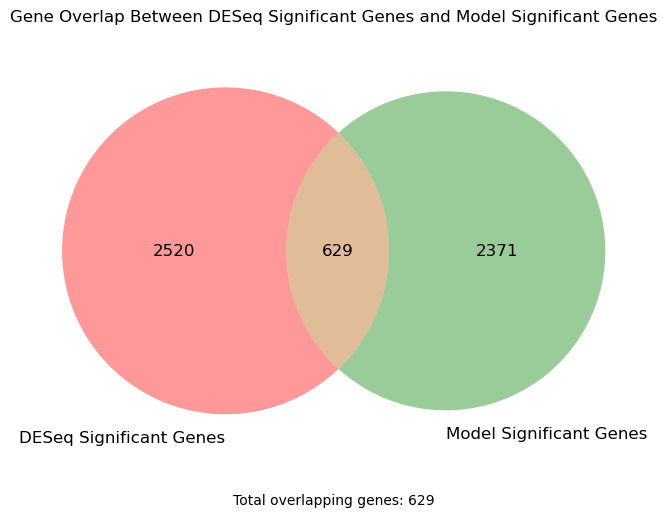

In [8]:
# Plot venn diagram of overlapping genes:

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def visualize_gene_overlap(file1, file2, set1_name='DESeq Genes', set2_name='Model Genes'):
    # Read genes from both files 
    def read_genes(filename):
        with open(filename, 'r') as f:
            return set(line.strip().lower() for line in f if line.strip())
    
    set1 = read_genes(file1)
    set2 = read_genes(file2)
    
    # Create Venn diagram
    plt.figure(figsize=(8, 6))
    v = venn2([set1, set2], set_labels=(set1_name, set2_name))
    
    for text in v.subset_labels:
        if text: text.set_fontsize(12)
    plt.title(f"Gene Overlap Between {set1_name} and {set2_name}", pad=20)
    
    # Add overlap count annotation
    overlap_count = len(set1 & set2)
    plt.text(0.5, -0.1, 
             f"Total overlapping genes: {overlap_count}",
             ha='center', va='top',
             transform=plt.gca().transAxes)
    
    plt.show()

# Get the Venn diagram
visualize_gene_overlap('Data/intersection_sig_genes.txt', 'model_sig_genes.txt',
                      set1_name='DESeq Significant Genes',
                      set2_name='Model Significant Genes')


### This code block trains the best model (XGBoost) on significant genes and the best model (SVM) on all genes, and compares the results.

Training XGBoost on Significant Genes...

XGBoost_Sig - Metrics:
CV Accuracy: 0.9485
Test Accuracy: 0.9777
Training SVM on All Genes...

SVM_All - Metrics:
CV Accuracy: 0.9497
Test Accuracy: 0.9821


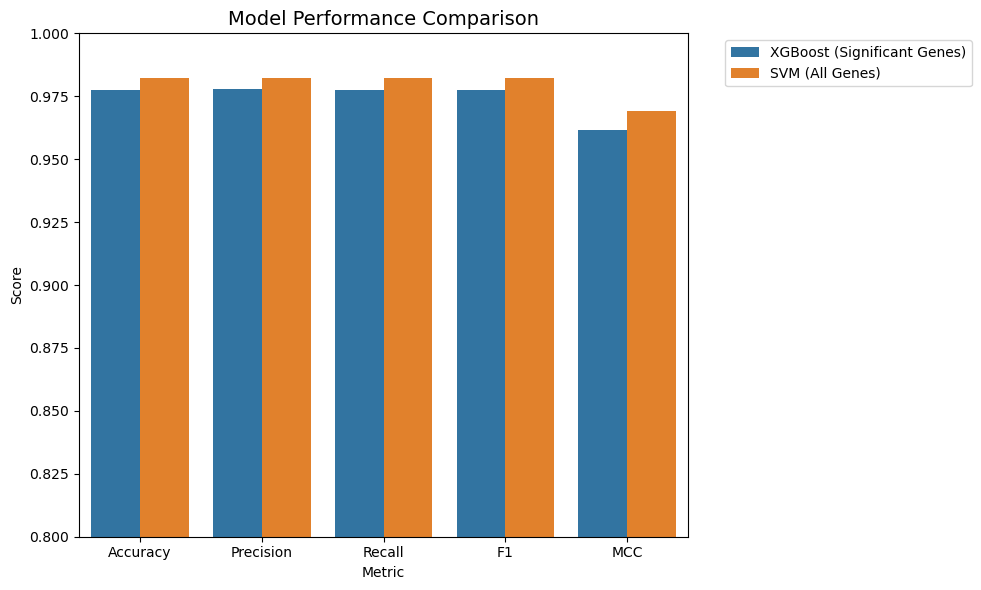

In [ ]:
from sig_genes import preprocess_data
from sig_vs_all_genes import evaluate_model_all_vs_sig, plot_comparison_random_all_vs_sig

## ----------------------- 1. Run Pipeline 4 -----------------------
def run_pipeline_4(train_csv, test_csv, significant_genes_file):
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    # XGBoost on Significant Genes
    with open(significant_genes_file, "r") as f:
        sig_genes = [line.strip() for line in f]

    # Prepare significant gene data
    train_sig = train_df[['cases.disease_type'] + sig_genes]
    test_sig = test_df[['cases.disease_type'] + sig_genes]
    
    X_train_sig, y_train_sig, scaler_sig, le_sig = preprocess_data(train_sig)
    X_test_sig, y_test_sig, _, _ = preprocess_data(test_sig, scaler=scaler_sig, fit_scaler=False)

    # Train XGBoost on significant genes
    xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                       random_state=42, eval_metric='mlogloss')
    print(f"Training XGBoost on Significant Genes...")
    xgb_sig_results = evaluate_model_all_vs_sig("XGBoost_Sig", xgb, X_train_sig, y_train_sig, X_test_sig, y_test_sig, le_sig)

    # SVM on All Genes
    # Prepare all genes data
    all_genes = train_df.columns.drop('cases.disease_type').tolist()
    train_all = train_df[['cases.disease_type'] + all_genes]
    test_all = test_df[['cases.disease_type'] + all_genes]
    
    X_train_all, y_train_all, scaler_all, le_all = preprocess_data(train_all)
    X_test_all, y_test_all, _, _ = preprocess_data(test_all, scaler=scaler_all, fit_scaler=False)

    # Train SVM on all genes
    svm = SVC(kernel='linear', probability=True)
    print(f"Training SVM on All Genes...")
    svm_all_results = evaluate_model_all_vs_sig("SVM_All", svm, X_train_all, y_train_all, X_test_all, y_test_all, le_all)

    return xgb_sig_results, svm_all_results

# ----------------------- 2. Run Pipeline -----------------------
if __name__ == "__main__":
    train_csv = "Data/compiled_train.csv"
    test_csv = "Data/compiled_test.csv"
    sig_genes_file = "Data/intersection_sig_genes.txt"

    # Get results
    xgb_results, svm_results = run_pipeline_4(train_csv, test_csv, sig_genes_file)
    
    # Plot comparison
    plot_comparison_random_all_vs_sig(xgb_results, svm_results)

